# LAB: Comparación de modelos

## Introducción

> **A tener en cuenta por el Instructor**: Este lab es largo y se puede completar con éxito si los puntos 1 y 2 se ejecutan bien. Ayude a la clase a trabajar a través de los puntos 1 y 2 y luego déles la solución si están luchando, para que puedan completar los puntos 3 y adelante.

En este lab vamos a comparar el rendimiento de todos los modelos que hemos aprendido hasta ahora, utilizando el [dataset de evaluación de autos](https://archive.ics.uci.edu/ml/machine-learning-databases/car/). Ya estamos muy familiarizado con este dataset. En particular, utilizaremos una división entrenamiento-prueba del dataset para observar las siguientes métricas:
- accuracy score
- confusion matrix
- classification report

Para los siguientes modelos:
- KNN
- KNN + Bagging
- Regresión logística
- Árboles de decisión
- Support Vector Machines
- Random Forest & Extra Trees

## Ejercicio

### Requisitos

1. Preparar los datos: codificar features, preprocesar
- Definir funciones útiles para tareas repetitivas
- KNN
    1. Evaluar el rendimiento de KNN
    - Evaluar el rendimiento de Bagging + KNN
- Evaluar el rendimiento de la Regresión logística
- Evaluar el rendimiento de Árboles de decisión
- Evaluar el rendimiento de Support Vector Machines
- Evaluar el rendimiento de Random Forest & Extra Trees
- Comparación final de los modelos

**Extra:**

- Repetir el análisis utilizando una codificación one hot para los features categóricos en lugar del mapeo a valores enteros. ¿Los resultados cambian?

## Recursos Adicionales

- [Dataset de evaluacion de autos](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
- [Bagging Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- [Grid Search](http://scikit-learn.org/stable/modules/grid_search.html)

## 1. Preparación de los datos

El [dataset de evaluación de autos](https://archive.ics.uci.edu/ml/machine-learning-databases/car/) está en la carpeta datasets. Ya debería estar familiarizado con el mismo.

1. Leer los datos en un dataframe de pandas
- Codificar adecuadamente los features categóricos: definir un mapeo que preserve el orden (asignando números más pequeños a palabras que indiquen cantidades más pequeñas)
- Separar los features de la variable objetivo en X e y

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv('car.csv') #Revisar la ruta del archivo
df.head()

buying  maint doors persons lug_boot safety acceptability
0  vhigh  vhigh     2       2    small    low         unacc
1  vhigh  vhigh     2       2    small    med         unacc
2  vhigh  vhigh     2       2    small   high         unacc
3  vhigh  vhigh     2       2      med    low         unacc
4  vhigh  vhigh     2       2      med    med         unacc

In [0]:
print (df.buying.unique())
print (df.maint.unique())
print (df.lug_boot.unique())
print (df.safety.unique())
print (df.acceptability.unique())
print (df.persons.unique())
print (df.doors.unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']
['2' '4' 'more']
['2' '3' '4' '5more']


In [0]:
map1 = {'low':1,
        'med':2,
        'high':3,
        'vhigh':4}
map2 = {'small':1,
        'med':2,
        'big':3}
map3 = {'unacc':1,
        'acc':2,
        'good':3,
        'vgood':4}
map4 = {'2': 2,
        '4': 4,
        'more': 5}
map5 = {'2': 2,
        '3': 3,
        '4': 4,
        '5more': 5}

In [0]:
features = [c for c in df.columns if c != 'acceptability']
dfn = df.copy()

dfn.buying= df.buying.map(map1)
dfn.maint= df.maint.map(map1)
dfn.lug_boot = df.lug_boot.map(map2)
dfn.persons = df.persons.map(map4)
dfn.doors = df.doors.map(map5)
dfn.safety = df.safety.map(map1)
dfn.acceptability = df.acceptability.map(map3)

X = dfn[features]
y = dfn['acceptability']
X.head()

buying  maint  doors  persons  lug_boot  safety
0       4      4      2        2         1       1
1       4      4      2        2         1       2
2       4      4      2        2         1       3
3       4      4      2        2         2       1
4       4      4      2        2         2       2

In [0]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying           1728 non-null int64
maint            1728 non-null int64
doors            1728 non-null int64
persons          1728 non-null int64
lug_boot         1728 non-null int64
safety           1728 non-null int64
acceptability    1728 non-null int64
dtypes: int64(7)
memory usage: 94.6 KB


## 2. Preparación útil

Dado que vamos a comparar varios modelos, resulta conveniente  escribir funciones auxiliares.

1. Separar X e y entre entrenamiento / prueba, usando el 30% como set de prueba, y asignando `random_state=42`
    - Asegurar de que los datos son mezclados y estratificados
2. Definir una función llamada `evaluate_model`, que entrene el modelo con el set de entrenamiento y lo evalué con el set de prueba. Y que calcule:
    - accuracy score
    - confusion matrix
    - classification report
3. Inicializar un diccionario global para almacenar los distintos modelos, para su posterior uso.


In [0]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    a = accuracy_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    print (cm)
    print (cr)
    
    return a

all_models = {}

## 3.a KNN

Comenzar con `KNeighborsClassifier`.

1. Inicializar un modelo KNN
- Evaluar su rendimiento con la función definida previamente
- Buscar el valor óptimo de K mediante Grid Search
    - Tener cuidado en cómo realizar la validación cruzada en Grid Search

In [0]:
from sklearn.neighbors import KNeighborsClassifier

a = evaluate_model(KNeighborsClassifier())

[[354   9   0   0]
 [  8 107   0   0]
 [  0   9  11   1]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.84      0.93      0.88       115
          3       1.00      0.52      0.69        21
          4       0.95      0.90      0.92        20

avg / total       0.95      0.94      0.94       519



In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': range(2,60)}
gsknn = GridSearchCV(KNeighborsClassifier(),params, n_jobs=-1,cv=KFold(n_splits=3, shuffle=True))

In [0]:
gsknn.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(2, 60)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
gsknn.best_params_

{'n_neighbors': 5}

In [0]:
gsknn.best_score_

0.95081018518518523

In [0]:
evaluate_model(gsknn.best_estimator_)

[[354   9   0   0]
 [  8 107   0   0]
 [  0   9  11   1]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.84      0.93      0.88       115
          3       1.00      0.52      0.69        21
          4       0.95      0.90      0.92        20

avg / total       0.95      0.94      0.94       519



0.94412331406551064

In [0]:
all_models['knn'] = {'model': gsknn.best_estimator_,
                     'score': gsknn.best_score_}

## 3.b Bagging + KNN

Habiendo encontrado el K óptimo, vamos a meter `KNeighborsClassifier` en un BaggingClassifier y ver si la puntuación mejora.

1. Usar el modelo KNN en un Bagging Classifier
- Evaluar el rendimiento
- Hacer un Grid Search sólo en los parámetros del Bagging Classifier

In [0]:
from sklearn.ensemble import BaggingClassifier
baggingknn = BaggingClassifier(KNeighborsClassifier())

In [0]:
evaluate_model(baggingknn)

[[354   9   0   0]
 [  7 106   2   0]
 [  0   5  15   1]
 [  0   4   0  16]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.85      0.92      0.89       115
          3       0.88      0.71      0.79        21
          4       0.94      0.80      0.86        20

avg / total       0.95      0.95      0.95       519



0.94605009633911363

In [0]:
bagging_params = {'n_estimators': [10, 20],
                  'max_samples': [0.7, 1.0],
                  'max_features': [0.7, 1.0],
                  'bootstrap_features': [True, False]}


gsbaggingknn = GridSearchCV(baggingknn,
                            bagging_params, n_jobs=-1,
                            cv=KFold(n_splits=3, shuffle=True))

In [0]:
gsbaggingknn.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20], 'max_samples': [0.7, 1.0], 'max_features': [0.7, 1.0], 'bootstrap_features': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
gsbaggingknn.best_params_

{'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 0.7,
 'n_estimators': 10}

In [0]:
all_models['gsbaggingknn'] = {'model': gsbaggingknn.best_estimator_,
                              'score': evaluate_model(gsbaggingknn.best_estimator_)}

[[357   5   1   0]
 [  9 106   0   0]
 [  0   7  12   2]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.98      0.98      0.98       363
          2       0.88      0.92      0.90       115
          3       0.92      0.57      0.71        21
          4       0.90      0.90      0.90        20

avg / total       0.95      0.95      0.95       519



## 4. Regresión Logística

Ahora veamos si la regresión logística funciona mejor

1. Inicializar una Regresión Logística y evaluarla
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [0]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
all_models['lr'] = {'model': lr,
                    'score': evaluate_model(lr)}

[[347  11   4   1]
 [ 59  53   3   0]
 [  5  15   1   0]
 [  0  19   0   1]]
             precision    recall  f1-score   support

          1       0.84      0.96      0.90       363
          2       0.54      0.46      0.50       115
          3       0.12      0.05      0.07        21
          4       0.50      0.05      0.09        20

avg / total       0.73      0.77      0.74       519



In [0]:
params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
          'penalty': ['l1', 'l2']}

gslr = GridSearchCV(lr,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gslr.fit(X, y)

print (gslr.best_params_)
print (gslr.best_score_)

all_models['gslr'] = {'model': gslr.best_estimator_,
                             'score': evaluate_model(gslr.best_estimator_)}

{'C': 100.0, 'penalty': 'l1'}
0.831018518519
[[344  14   4   1]
 [ 48  64   3   0]
 [  4  14   2   1]
 [  0   8   0  12]]
             precision    recall  f1-score   support

          1       0.87      0.95      0.91       363
          2       0.64      0.56      0.60       115
          3       0.22      0.10      0.13        21
          4       0.86      0.60      0.71        20

avg / total       0.79      0.81      0.80       519



In [0]:
gsbagginglr = GridSearchCV(BaggingClassifier(gslr.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbagginglr.fit(X, y)

print (gsbagginglr.best_params_)
print (gsbagginglr.best_score_)

all_models['gsbagginglr'] = {'model': gsbagginglr.best_estimator_,
                             'score': evaluate_model(gsbagginglr.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
0.831018518519
[[344  14   4   1]
 [ 50  62   3   0]
 [  3  15   2   1]
 [  0   8   0  12]]
             precision    recall  f1-score   support

          1       0.87      0.95      0.91       363
          2       0.63      0.54      0.58       115
          3       0.22      0.10      0.13        21
          4       0.86      0.60      0.71        20

avg / total       0.79      0.81      0.79       519



## 5. Árboles de decisión

Comprobemos como rinden los Árboles de Decisión

1. Inicializar un árbol de decisión y evaluarlo
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
all_models['dt'] = {'model': dt,
                    'score': evaluate_model(dt)}

[[360   3   0   0]
 [ 11 102   2   0]
 [  1   4  16   0]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.97      0.99      0.98       363
          2       0.93      0.89      0.91       115
          3       0.89      0.76      0.82        21
          4       1.00      0.95      0.97        20

avg / total       0.96      0.96      0.96       519



In [0]:
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gsdt = GridSearchCV(dt,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsdt.fit(X, y)
print (gsdt.best_params_)
print (gsdt.best_score_)

all_models['gsdt'] = {'model': gsdt.best_estimator_,
                      'score': evaluate_model(gsdt.best_estimator_)}

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.975115740741
[[361   2   0   0]
 [ 14 100   1   0]
 [  1   5  15   0]
 [  0   0   0  20]]
             precision    recall  f1-score   support

          1       0.96      0.99      0.98       363
          2       0.93      0.87      0.90       115
          3       0.94      0.71      0.81        21
          4       1.00      1.00      1.00        20

avg / total       0.96      0.96      0.95       519



In [0]:
gsbaggingdt = GridSearchCV(BaggingClassifier(gsdt.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbaggingdt.fit(X, y)

print (gsbaggingdt.best_params_)
print (gsbaggingdt.best_score_)

all_models['gsbaggingdt'] = {'model': gsbaggingdt.best_estimator_,
                             'score': evaluate_model(gsbaggingdt.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
0.96875
[[360   2   1   0]
 [  7 106   1   1]
 [  1   4  14   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.98      0.99      0.98       363
          2       0.94      0.92      0.93       115
          3       0.88      0.67      0.76        21
          4       0.86      0.95      0.90        20

avg / total       0.96      0.96      0.96       519



## 6. Support Vector Machines

Analicemos como funciona SVM

1. Inicializar un SVM y evaluarlo
- Buscar los parámetros óptimos con Grid Search
- Ver si Bagging mejora el resultado

In [0]:
from sklearn.svm import SVC

svm = SVC()
all_models['svm'] = {'model': svm,
                     'score': evaluate_model(svm)}

[[352  11   0   0]
 [  4 110   1   0]
 [  0   5  14   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.97      0.98       363
          2       0.87      0.96      0.91       115
          3       0.93      0.67      0.78        21
          4       0.90      0.95      0.93        20

avg / total       0.96      0.95      0.95       519



In [0]:
params = {'C': [0.01, 0.1, 1.0, 10.0, 30.0, 100.0],
          'gamma': ['auto', 0.1, 1.0, 10.0],
          'kernel': ['linear', 'rbf']}


gssvm = GridSearchCV(svm,
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gssvm.fit(X, y)
print (gssvm.best_params_)
print (gssvm.best_score_)

all_models['gssvm'] = {'model': gssvm.best_estimator_,
                      'score': evaluate_model(gssvm.best_estimator_)}

{'C': 100.0, 'gamma': 'auto', 'kernel': 'rbf'}
0.982060185185
[[363   0   0   0]
 [  4 111   0   0]
 [  0   2  19   0]
 [  0   0   0  20]]
             precision    recall  f1-score   support

          1       0.99      1.00      0.99       363
          2       0.98      0.97      0.97       115
          3       1.00      0.90      0.95        21
          4       1.00      1.00      1.00        20

avg / total       0.99      0.99      0.99       519



In [0]:
gsbaggingsvm = GridSearchCV(BaggingClassifier(gssvm.best_estimator_),
                           bagging_params, n_jobs=-1,
                           cv=KFold(n_splits=3, shuffle=True))

gsbaggingsvm.fit(X, y)

print (gsbaggingsvm.best_params_)
print (gsbaggingsvm.best_score_)

all_models['gsbaggingsvm'] = {'model': gsbaggingsvm.best_estimator_,
                             'score': evaluate_model(gsbaggingsvm.best_estimator_)}

{'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
0.982060185185
[[363   0   0   0]
 [  5 110   0   0]
 [  0   3  16   2]
 [  0   0   0  20]]
             precision    recall  f1-score   support

          1       0.99      1.00      0.99       363
          2       0.97      0.96      0.96       115
          3       1.00      0.76      0.86        21
          4       0.91      1.00      0.95        20

avg / total       0.98      0.98      0.98       519



## 7. Random Forest & Extra Trees

Ahora veamos por último como funcionan Random Forest y Extra Trees

1. Inicializar RF y ET y evaluarlos
- Buscar los parámetros óptimos con Grid Search


In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier()
all_models['rf'] = {'model': rf,
                    'score': evaluate_model(rf)}



et = ExtraTreesClassifier()
all_models['et'] = {'model': et,
                    'score': evaluate_model(et)}


[[360   2   1   0]
 [  5 110   0   0]
 [  0   6  15   0]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.99      0.99       363
          2       0.92      0.96      0.94       115
          3       0.94      0.71      0.81        21
          4       1.00      0.95      0.97        20

avg / total       0.97      0.97      0.97       519

[[359   4   0   0]
 [  7 106   2   0]
 [  0   6  13   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.98      0.99      0.98       363
          2       0.91      0.92      0.91       115
          3       0.87      0.62      0.72        21
          4       0.90      0.95      0.93        20

avg / total       0.96      0.96      0.96       519



In [0]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gsrf = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gsrf.fit(X, y)
print (gsrf.best_params_)
print (gsrf.best_score_)

all_models['gsrf'] = {'model': gsrf.best_estimator_,
                      'score': evaluate_model(gsrf.best_estimator_)}

{'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
0.975694444444
[[357   5   1   0]
 [  5 109   0   1]
 [  0   4  15   2]
 [  0   2   0  18]]
             precision    recall  f1-score   support

          1       0.99      0.98      0.98       363
          2       0.91      0.95      0.93       115
          3       0.94      0.71      0.81        21
          4       0.86      0.90      0.88        20

avg / total       0.96      0.96      0.96       519



In [0]:
gset = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=KFold(n_splits=3, shuffle=True))

gset.fit(X, y)
print (gset.best_params_)
print (gset.best_score_)

all_models['gset'] = {'model': gset.best_estimator_,
                      'score': evaluate_model(gset.best_estimator_)}

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
0.974537037037
[[359   4   0   0]
 [  3 110   1   1]
 [  0   4  16   1]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.99      0.99      0.99       363
          2       0.92      0.96      0.94       115
          3       0.94      0.76      0.84        21
          4       0.90      0.95      0.93        20

avg / total       0.97      0.97      0.97       519



## 8. Comparación de modelos

Vamos a comparar los resultados de los diferentes modelos.

1. Haga un gráfico de barras de los resultados de los mejores modelos. ¿Cuál es el ganador?
- Volver a evaluar todos los modelos usando una validación cruzada estratificada de 3-fold
- Hacer un gráfico de barras, mostrando el valor medio y desvío del resultado de la validación cruzada. ¿Es el mismo ganador?


score
model                 
gssvm         0.988439
gsbaggingsvm  0.980732
rf            0.971098
gset          0.971098
gsbaggingdt   0.961464
gsrf          0.961464
dt            0.957611
et            0.957611
gsdt          0.955684
svm           0.953757
knn           0.950810
gsbaggingknn  0.949904
gslr          0.813102
gsbagginglr   0.809249
lr            0.774566

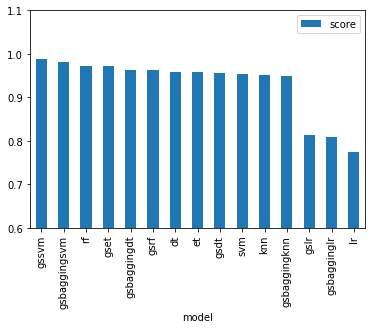

In [0]:
scores = pd.DataFrame([(k, v['score']) for k, v in all_models.items()],
             columns=['model', 'score']).set_index('model').sort_values('score', ascending=False)


scores.plot(kind='bar')
plt.ylim(0.6, 1.1)

scores

In [0]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def retest(model):
    scores = cross_val_score(model, X, y,
                             cv=StratifiedKFold(n_splits=3, shuffle=True),
                             n_jobs=-1)
    m = scores.mean()
    s = scores.std()
    
    return m, s

for k, v in all_models.items():
    cvres = retest(v['model'])
    print (k), 
    all_models[k]['cvres'] = cvres
    

knn
gsbaggingknn
lr
gslr
gsbagginglr
dt
gsdt
gsbaggingdt
svm
gssvm
gsbaggingsvm
rf
et
gsrf
gset


score     error
model                           
gsbaggingsvm  0.983792  0.002971
gssvm         0.983790  0.004581
gsbaggingdt   0.980326  0.004319
dt            0.977423  0.005144
gsrf          0.976259  0.012901
gset          0.972223  0.003745
gsdt          0.969910  0.002123
et            0.961229  0.006685
rf            0.961223  0.003324
svm           0.953705  0.002143
knn           0.950797  0.009721
gsbaggingknn  0.936931  0.008100
gslr          0.833326  0.010034
gsbagginglr   0.832180  0.003073
lr            0.799188  0.014359

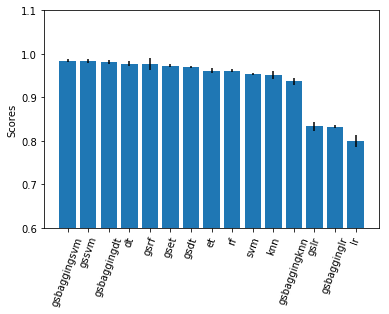

In [0]:
cvscores = pd.DataFrame([(k, v['cvres'][0], v['cvres'][1] ) for k, v in all_models.items()],
                        columns=['model', 'score', 'error']).set_index('model').sort_values('score', ascending=False)


fig, ax = plt.subplots()
rects1 = ax.bar(range(len(cvscores)), cvscores.score,
                yerr=cvscores.error,
                tick_label=cvscores.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=70)
plt.ylim(0.6, 1.1)

cvscores


## Extra

Hemos codificado los datos utilizando un mapa que preservaba el orden.
¿Cómo cambiarían los resultados si codificamos los datos categóricos utilizando `pd.get_dummies` o `OneHotEncoder` para codificarlos como variables binarias?

1. Repetir el análisis para este escenario. ¿Es mejor?
- Experimentar con otros modelos u otros parámetros, ¿puedes obtener el mejor resultado de la clase?

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline

all_modelsoh={}

onehotpipe = make_pipeline(OneHotEncoder() , dt)

all_modelsoh['onehotpipe'] = {'model': onehotpipe,
                            'score': evaluate_model(onehotpipe)}


[[358   4   1   0]
 [ 18  96   1   0]
 [  0   1  18   2]
 [  0   1   0  19]]
             precision    recall  f1-score   support

          1       0.95      0.99      0.97       363
          2       0.94      0.83      0.88       115
          3       0.90      0.86      0.88        21
          4       0.90      0.95      0.93        20

avg / total       0.95      0.95      0.94       519



In [0]:
# El score del DecisionTree baja cuando usamos OneHotEncoder en lugar de una escala numérica.